In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st
from scipy.stats import wasserstein_distance
import csv
import pandas as pd

# The true distribution
We take the true distribution of $y$ to be $\mathcal{Beta}(3,3)$ drawn on $[-1,1]$. i.e. we have unormalized density
<br>
<center> $(1+y)^2(1-y)^2$

We seek to find $x^*$ such that it solves $\min_x E[c(x,y)]$ where
<br>
<center>$c(x,y) = 3x^2 + 6xy^2 - 2x^2y - 7xy$.

This can be solved analytically, whereby $x$ is minimised at $-1/7$ = -0.14286.

Text(0.5,1,'True Distribution of Y')

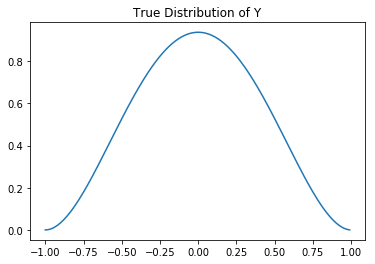

In [2]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [3]:
# the cost function we would like to minimise/maximise
def f(x,y, weights=None,find_mean=True):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y
    if find_mean:
        if weights is not None:
            return np.average(function,axis=0,weights=weights)
        else:
            return np.mean(function,axis=0)
    else:
        return function

In [4]:
# the cost function we would like to minimise/maximise
def f_convex(x,y, weights=None,find_mean=True):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y -5*x
    if find_mean:
        if weights is not None:
            return np.average(function,axis=0,weights=weights)
        else:
            return np.mean(function,axis=0)
    else:
        return function

In [5]:
def df_dy(x,y):
    return 12*x*y - 2*x**2 - 7*x

In [6]:
def SAA_minimise(samples, func, p0=0.0):
    res = minimize(func,p0,args=(samples))
    return res.x

In [7]:
def f_maximise(y,x):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y
    return -np.mean(function,axis=0)

In [15]:
def f_convex_maximise(y,x):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y - 5*x
    return -np.mean(function,axis=0)

In [8]:
def wasserstein_constraint(Sx,Sy,delta):
    distance = wasserstein_distance(Sx,Sy)
    return  delta-distance

In [25]:
def wasserstein_robustification(y,x_star,func,constraint,bound):
    res = minimize(func,y,args=(x_star),constraints=constraint,bounds=bound)
    return res.x

In [31]:
def plot_sample_change(x_star,Sy,new_y,func):
    
    # get a plot of the cost function
    temp_y = np.linspace(np.min(Sy),np.max(Sy),500)
    full_cost = func(x_star,temp_y,find_mean=False)
    
    # get cost of samples
    sub_cost = func(x_star,Sy,find_mean=False)
    # cost of changed samples
    altered = func(x_star,new_y,find_mean=False)
    
    # check which samples have changed
    changed_index = np.isclose(Sy,new_y,atol=1e-2) == False
    
    changed_samples = new_y[changed_index]
    changed_cost = func(x_star,changed_samples,find_mean=False)
    original_samples = Sy[changed_index]
    original_cost = sub_cost[changed_index]
    
    # plot the hraph
    plt.figure(figsize=(10,8))
    plt.plot(temp_y,full_cost,label='cost function')
    plt.plot(Sy,sub_cost,'o',label='samples')

    plt.plot(changed_samples,original_cost,'o',label='altered samples')
    for i in range(len(changed_cost)):
        plt.arrow(original_samples[i],
                  original_cost[i],
                  (changed_samples[i]-original_samples[i])*0.7,
                  0,head_width=0.02,length_includes_head=False)
    plt.legend()

# Initial test

In [73]:
Sy = Y.rvs(100)
Sy = np.sort(Sy)

In [74]:
x_star = SAA_minimise(Sy,f)

In [75]:
#temp = minimize(f_maximise,Sy,args=(x_star),constraints={'type':'eq','fun':wasserstein_constraint,'args':[Sy,0.01]})
delta = 0.01
constraint = {'type':'ineq','fun':wasserstein_constraint,'args':[Sy,delta]}
bound = [(-1,1)]*len(Sy)
new_y = wasserstein_robustification(Sy,x_star,f_maximise,constraint,bound)

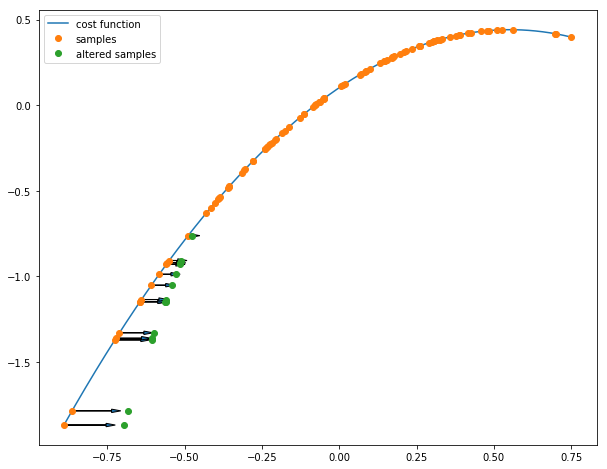

In [76]:
plot_sample_change(x_star,Sy,new_y,f)

# second cost function

This still needs to be fixed.

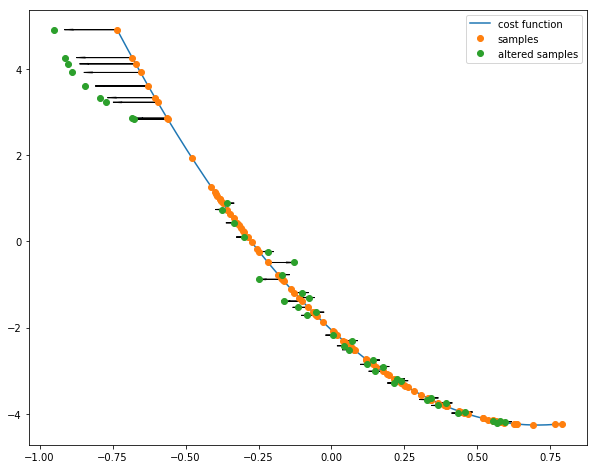

In [41]:
#temp = minimize(f_maximise,Sy,args=(x_star),constraints={'type':'eq','fun':wasserstein_constraint,'args':[Sy,0.01]})
delta = 0.00000001
x_star = SAA_minimise(Sy,f_convex)
bound = [(-1,1)]*len(Sy)
constraint = {'type':'ineq','fun':wasserstein_constraint,'args':[Sy,delta]}
new_y = wasserstein_robustification(Sy,x_star,f_convex_maximise,constraint,bound)
plot_sample_change(x_star,Sy,new_y,f_convex)

In [99]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 100

# number of samples for each experiment
N = 10

delta = [0.01,0.015,0.02]

In [114]:
#%%time
# SAA_results = np.zeros((n_iter,len(N)))
# wasserstein_results = np.zeros((n_iter,len(N),len(delta)))

#start_time = timeit.default_timer()

with open('wasser_N10.csv', 'w') as csvfile:
    delta = [0.01,0.015,0.02]
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['SAA'] + delta)
    # define the bounds
    bound = [(-1,1)]*N
    for k in range(n_iter):
        # obtain the samples
        S = Y.rvs(N)
        S = np.sort(S)
        # obtain result for SAA
        x_star = SAA_minimise(S,f)
        # perform robustification for different delta
        wasser_results = []
        for i in range(len(delta)):
            constraint = {'type':'ineq','fun':wasserstein_constraint,'args':[S,delta[i]]}
            new_S = wasserstein_robustification(S,x_star,f_maximise,constraint,bound)
            temp = SAA_minimise(new_S,f)
            wasser_results += [float(temp)]
        #result_list = [float(x_star)] + 
        writer.writerow([float(x_star)] + wasser_results)

In [115]:
wasser_results

[-0.21639099018477997, -0.20506616948184153, -0.19391560766115523]

In [116]:
pd.read_csv('wasser_N10.csv')

,SAA,0.01,0.015,0.02
0,-0.188058,-0.165884,-0.155084,-0.144457
1,-0.052265,-0.030577,-0.020233,-0.010110
2,-0.099473,-0.081584,-0.072943,-0.064491
3,-0.328879,-0.307812,-0.297564,-0.287453
4,-0.112504,-0.092713,-0.083457,-0.074635
5,-0.297262,-0.273335,-0.261965,-0.250998
6,-0.076363,-0.051876,-0.040323,-0.029199
7,-0.079841,-0.059237,-0.049511,-0.039988
8,0.063867,0.012218,0.029290,0.016773
9,-0.293709,-0.271770,-0.261073,-0.250551


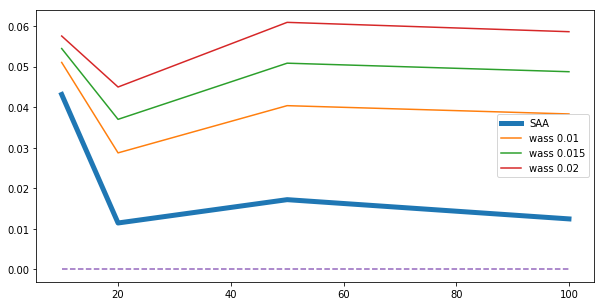

In [88]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.abs(np.mean(wasserstein_results,axis=0)+1.0/7))
#plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SAA approximation')
#plt.plot(N,np.abs(np.mean(phi_results,axis=0)+1.0/7),label='Phi Divergence')
#plt.plot(N,np.abs(np.mean(wasserstein_results,axis=0)+1.0/7),label='Wasserstein')

plt.plot(N,[0.0]*len(N),'--',label='True value')
strings = ['wass '+ str(ele) for ele in delta]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))

Text(0.5,1,'Standard Deviation')

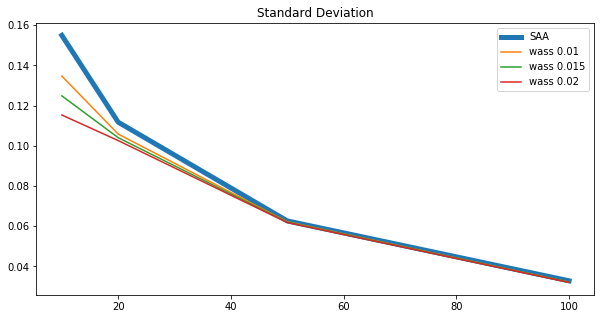

In [89]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.std(SAA_results,axis=0),label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.std(wasserstein_results[:,:,:],axis=0))

strings = ['wass '+ str(ele) for ele in delta]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))
plt.title('Standard Deviation')

In [90]:
diff_wasser = np.abs(SAA_results - wasserstein_results[:,:,1])

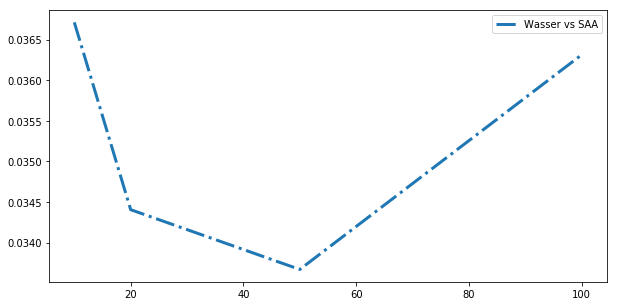

In [91]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.mean(diff_wasser,axis=0),label='Wasser vs SAA',ls='-.',lw=3.0)
plt.legend()

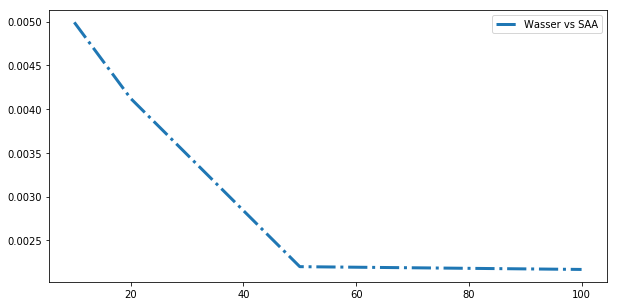

In [92]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.std(diff_wasser,axis=0),label='Wasser vs SAA',ls='-.',lw=3.0)
plt.legend()

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


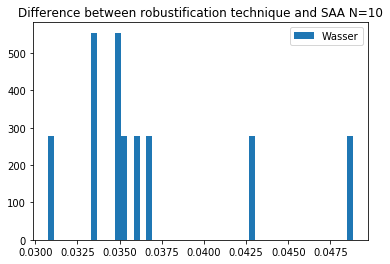

In [94]:
plt.hist(diff_wasser[:,0],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=10')
plt.legend()

In [ ]:
plt.hist(diff_phi[:,1],bins=50,normed=True,label='Phi')
plt.hist(diff_wasser[:,1],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=25')
plt.legend()

In [ ]:
plt.hist(diff_phi[:,2],bins=50,normed=True,label='Phi')



plt.hist(diff_wasser[:,2],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=50')